<a href="https://colab.research.google.com/github/sid5150/Melanoma-Detection-Assignment/blob/main/siddharth_shankar_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Create a working directory
!mkdir -p /content/skin_cancer_project

# Copy and extract the zip file from Google Drive
!cp "/content/gdrive/My Drive/Copy of CNN_assignment.zip" "/content/skin_cancer_project/"
!cd /content/skin_cancer_project && unzip -q "Copy of CNN_assignment.zip"

# Let's check what we got after extraction
!ls "/content/skin_cancer_project"

Mounted at /content/gdrive
'Copy of CNN_assignment.zip'  'Skin cancer ISIC The International Skin Imaging Collaboration'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
base_dir = "/content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(base_dir + "/Train")
data_dir_test = pathlib.Path(base_dir + "/Test")

# Let's verify the paths exist and check the number of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of training images:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of test images:", image_count_test)

# Let's also verify the class directories
print("\nTraining directories:")
print(os.listdir(data_dir_train))

Number of training images: 2239
Number of test images: 118

Training directories:
['basal cell carcinoma', 'seborrheic keratosis', 'vascular lesion', 'pigmented benign keratosis', 'nevus', 'dermatofibroma', 'squamous cell carcinoma', 'actinic keratosis', 'melanoma']


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names# Get and print class names
class_names = train_ds.class_names
print("Classes of skin cancer:", class_names)

Classes of skin cancer: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

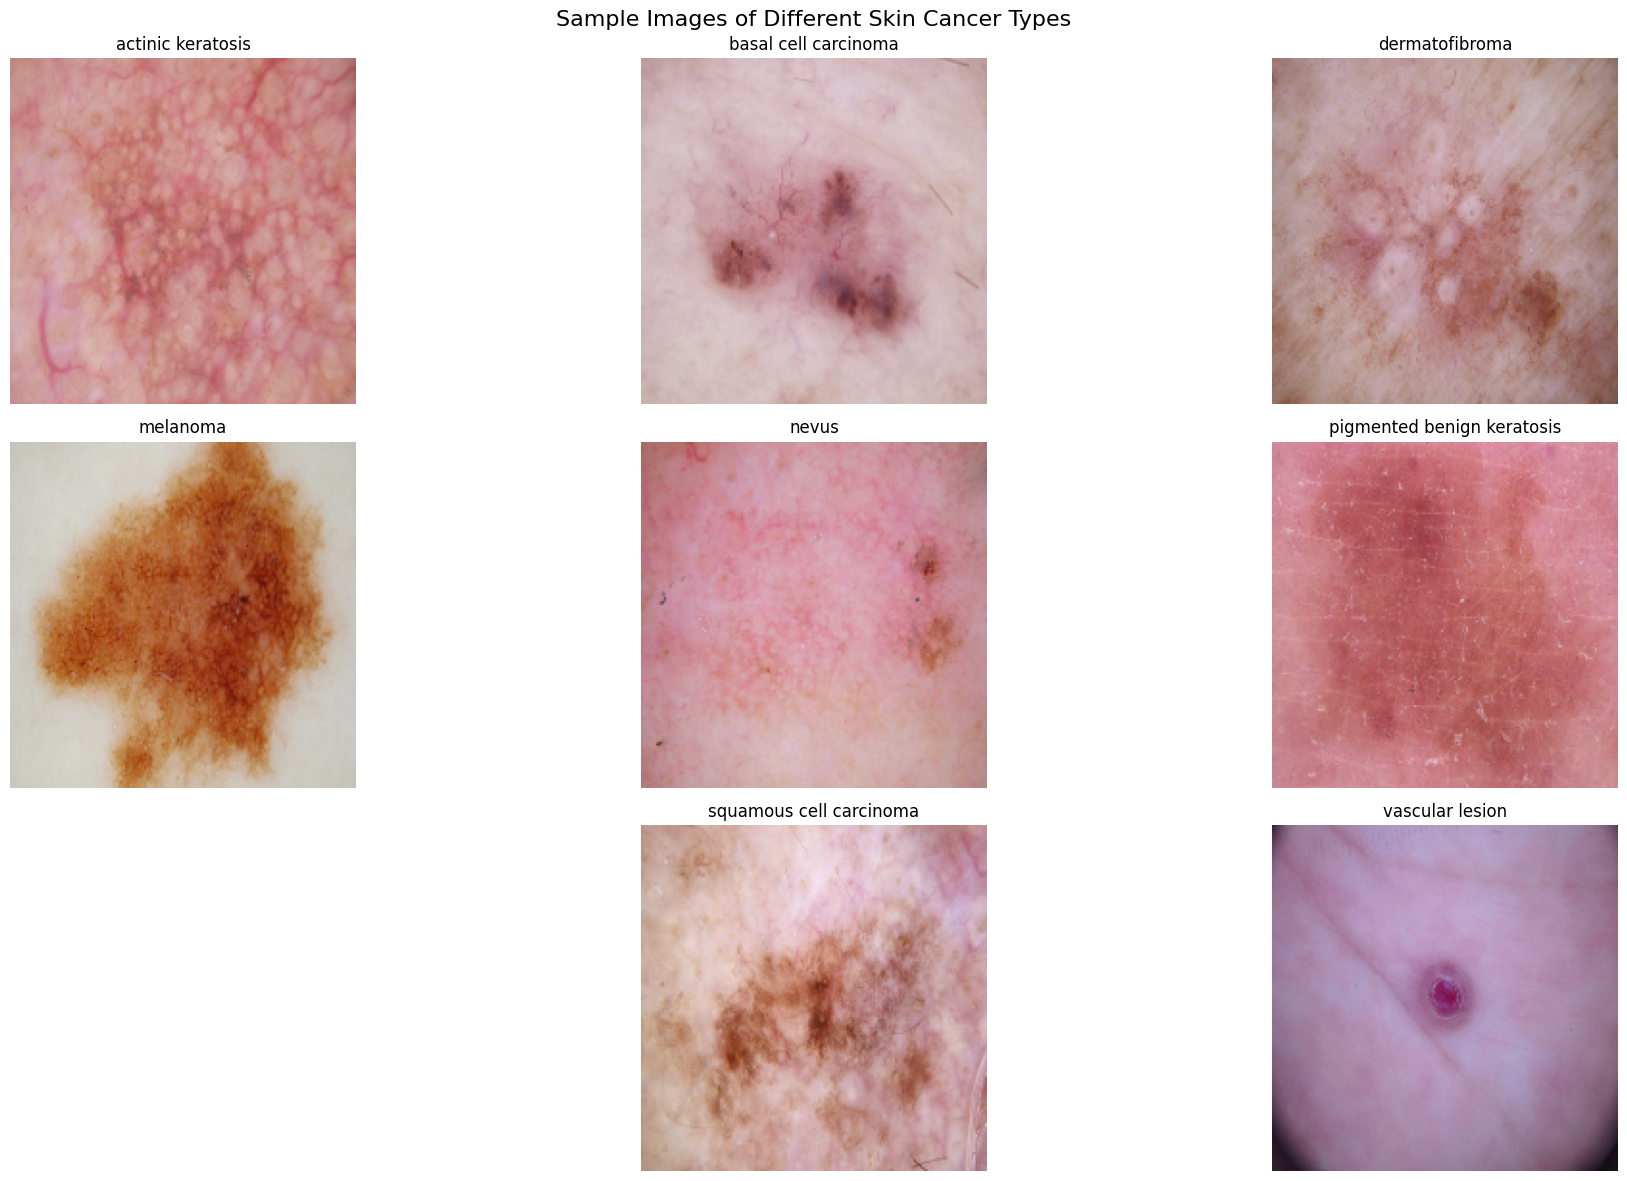

Class 0: actinic keratosis
Class 1: basal cell carcinoma
Class 2: dermatofibroma
Class 3: melanoma
Class 4: nevus
Class 5: pigmented benign keratosis
Class 6: seborrheic keratosis
Class 7: squamous cell carcinoma
Class 8: vascular lesion


In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Function to plot images in a grid
plt.figure(figsize=(20, 12))

# Get a batch of images from the training dataset
for images, labels in train_ds.take(1):
    # Loop through each class (0-8)
    for i in range(9):
        # Find an image from the current class
        class_indices = tf.where(labels == i)
        if len(class_indices) > 0:
            idx = class_indices[0]

            # Create subplot
            ax = plt.subplot(3, 3, i + 1)

            # Display image
            plt.imshow(images[idx.numpy()[0]].numpy().astype("uint8"))

            # Add title (class name)
            plt.title(class_names[i], fontsize=12)

            # Remove axes
            plt.axis("off")

# Adjust layout and display
plt.suptitle("Sample Images of Different Skin Cancer Types", fontsize=16)
plt.tight_layout()
plt.show()

# Print class names with their index for reference
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
# Create the CNN model
model = Sequential([
    # Start with Input layer explicitly
    layers.Input(shape=(img_height, img_width, 3)),

    # Normalize pixel values
    layers.Rescaling(1./255),

    # First Convolutional Block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    # Second Convolutional Block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    # Third Convolutional Block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    # Fourth Convolutional Block
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    # Flatten the output and feed it into dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Output layer with 9 units (one for each class)
    layers.Dense(9, activation='softmax')
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer is a good default choice
    loss='sparse_categorical_crossentropy',  # Appropriate for multi-class classification with integer labels
    metrics=['accuracy']
)

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 11, 11, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      15,860,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 16,384,201 (62.50 MB)

 Trainable params: 16,383,241 (62.50 MB)

 Non-trainable params: 960 (3.75 KB)

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.2497 - loss: 9.5865 - val_accuracy: 0.1857 - val_loss: 3.1947
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.2916 - loss: 4.6302 - val_accuracy: 0.2081 - val_loss: 3.3106
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3049 - loss: 2.3476 - val_accuracy: 0.2237 - val_loss: 3.2078
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3205 - loss: 1.9935 - val_accuracy: 0.2125 - val_loss: 2.8311
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3531 - loss: 1.9311 - val_accuracy: 0.2103 - val_loss: 3.0579
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3499 - loss: 1.8711 - val_accuracy: 0.2483 - val_loss: 2.2737
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3579 - loss: 1.8161 - val_accuracy: 0.2192 - val_loss: 3.3025
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3639 - loss: 1.8123 - val_accuracy: 0.3266 

### Visualizing training results

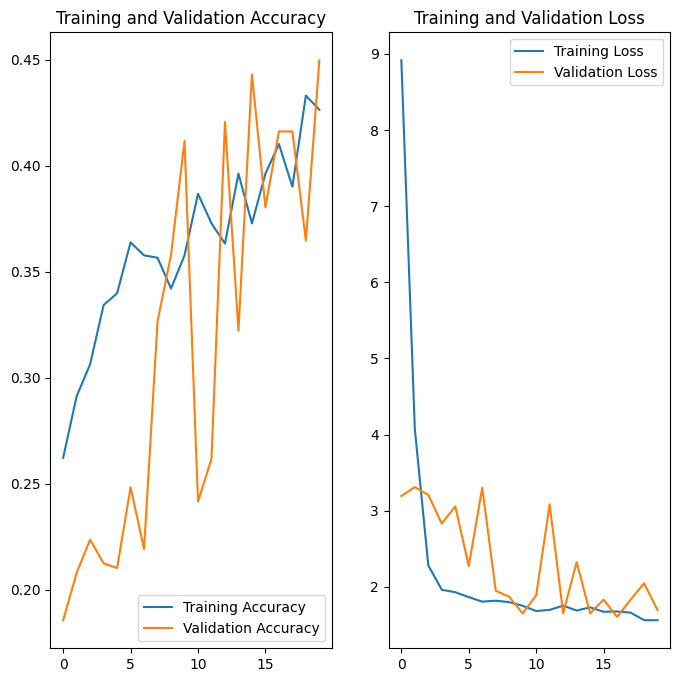

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Overall Performance:

Final training accuracy: ~43%
Final validation accuracy: ~45%
These are relatively low accuracies for a 9-class problem


Evidence of Underfitting:

Both training and validation accuracy are low (below 50%)
Training accuracy hasn't plateaued, suggesting the model hasn't reached its full learning potential
Loss values are relatively high throughout training
Model struggles to capture the complex patterns in the skin cancer images


Training Dynamics:

Training starts with very high loss (~9.5) that quickly drops in the first few epochs
Gradual improvement in accuracy over epochs, but still not satisfactory
Validation performance is unstable, showing significant fluctuations


Recommendations for Improvement:

Implement data augmentation to increase training data variety
Consider a deeper network or using more complex architectures
The model might benefit from:

Additional convolutional layers
Learning rate adjustments
More training epochs
Class balancing techniques

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# First augmentation phase using data augmentation strategy
data_augmentation = Sequential([
    # Use simple augmentation as recommended in the initial phase
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Create improved model with augmentation
model = Sequential([
    # Input layer
    layers.Input(shape=(img_height, img_width, 3)),

    # Data augmentation layer
    data_augmentation,

    # Normalize pixel values
    layers.Rescaling(1./255),

    # Convolutional blocks
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2541 - loss: 15.8598 - val_accuracy: 0.0492 - val_loss: 4.5610
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.2205 - loss: 2.1987 - val_accuracy: 0.0515 - val_loss: 6.6995
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.1991 - loss: 2.1624 - val_accuracy: 0.0515 - val_loss: 6.8840
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2311 - loss: 2.1133 - val_accuracy: 0.0492 - val_loss: 6.7921
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.2454 - loss: 2.0680 - val_accuracy: 0.0403 - val_loss: 4.7426
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.2626 - loss: 2.0172 - val_accuracy: 0.1029 - val_loss: 3.3988
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2503 - loss: 2.0239 - val_accuracy: 0.2640 - val_loss: 2.2399
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2758 - loss: 1.9455 - val_accuracy: 0.3356 -

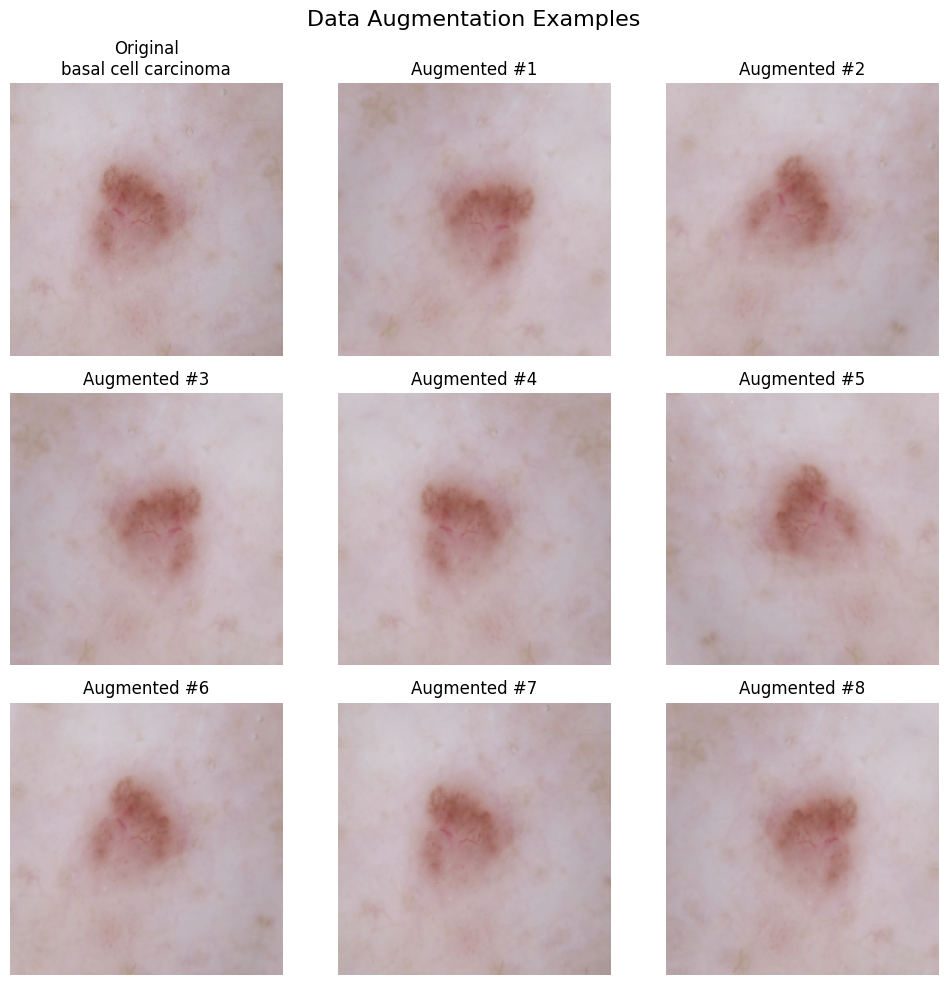

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Get a single image batch for visualization
for images, labels in train_ds.take(1):
    # Select first image from batch
    sample_image = images[0]
    sample_label = class_names[labels[0]]

    plt.figure(figsize=(10, 10))

    # Plot original image
    plt.subplot(3, 3, 1)
    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.title(f'Original\n{sample_label}')
    plt.axis('off')

    # Apply augmentation multiple times and plot
    for i in range(8):
        # Apply data augmentation
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))[0]

        plt.subplot(3, 3, i + 2)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title(f'Augmented #{i+1}')
        plt.axis('off')

    plt.suptitle('Data Augmentation Examples', fontsize=16)
    plt.tight_layout()
    plt.show()

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Create improved model architecture
model = Sequential([
    # Input and data augmentation
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,

    # Normalize pixel values
    layers.Rescaling(1./255),

    # First Convolutional Block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Second Convolutional Block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third Convolutional Block
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])




### Compiling the model

In [25]:
## Your code goes here
# Compile with modified learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### Training the model

In [26]:
# Train the model for 20 epochs
epochs = 20

history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=epochs,
   verbose=1
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 372ms/step - accuracy: 0.2461 - loss: 2.8821 - val_accuracy: 0.0403 - val_loss: 2.7222
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.3807 - loss: 2.2543 - val_accuracy: 0.2438 - val_loss: 3.7051
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.4194 - loss: 2.0392 - val_accuracy: 0.1499 - val_loss: 3.5559
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.4459 - loss: 1.9161 - val_accuracy: 0.2058 - val_loss: 4.0041
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.4409 - loss: 1.7652 - val_accuracy: 0.1521 - val_loss: 3.6753
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.4689 - loss: 1.7277 - val_accuracy: 0.1566 - val_loss: 3.8234
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.4552 - loss: 1.7283 - val_accuracy: 0.2125 - val_loss: 3.4420
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - accuracy: 0.4817 - loss: 1.6185 - val_accu

### Visualizing the results

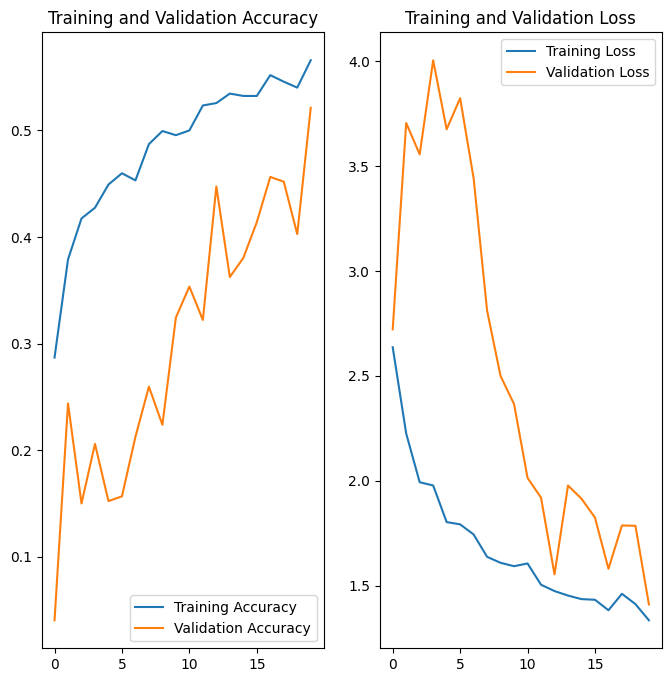

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Improvement from Previous Model:


The model has significantly improved from the previous run:

Training accuracy increased from ~28% to ~57%
Validation accuracy improved from ~36% to ~52%
Final loss values are lower (training: 1.34, validation: 1.41)




Training Dynamics:


Training accuracy shows steady improvement from 24% to 57%
Validation accuracy improved from 4% to 52%
Both loss curves show a general downward trend


Signs of Moderate Overfitting:


Training accuracy (57%) is slightly higher than validation accuracy (52%)
Training loss (1.34) is slightly lower than validation loss (1.41)
The gap between training and validation metrics is smaller than before, suggesting better generalization


Areas for Further Improvement:


Overall accuracy is still relatively low for a 9-class problem
The model might benefit from:

Class balancing
Using the Augmentor library
Addressing potential class imbalance issues

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

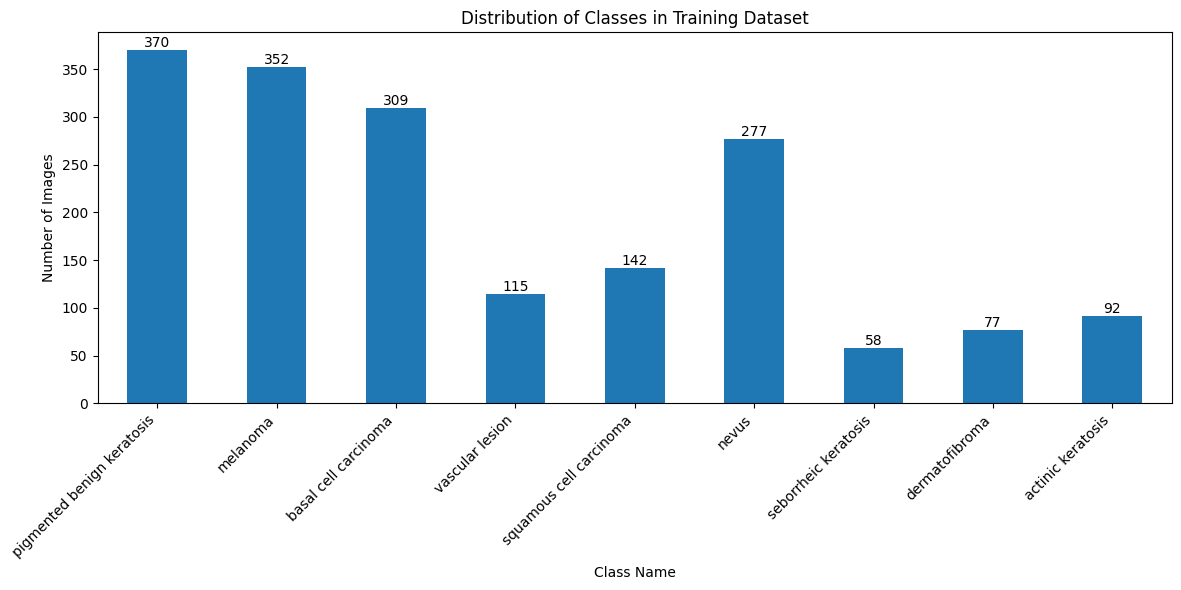


Class Distribution Statistics:

Absolute counts:
pigmented benign keratosis: 370 images
melanoma: 352 images
basal cell carcinoma: 309 images
vascular lesion: 115 images
squamous cell carcinoma: 142 images
nevus: 277 images
seborrheic keratosis: 58 images
dermatofibroma: 77 images
actinic keratosis: 92 images

Percentages:
pigmented benign keratosis: 20.65%
melanoma: 19.64%
basal cell carcinoma: 17.24%
vascular lesion: 6.42%
squamous cell carcinoma: 7.92%
nevus: 15.46%
seborrheic keratosis: 3.24%
dermatofibroma: 4.3%
actinic keratosis: 5.13%

Class with least samples: seborrheic keratosis (58 images)
Class with most samples: pigmented benign keratosis (370 images)
Imbalance ratio (max/min): 6.38


In [28]:
# Get class distribution from the training dataset
import numpy as np

# Initialize a dictionary to store class counts
class_counts = {}

# Iterate through the training dataset
for images, labels in train_ds:
   # Count occurrences of each label
   for label in labels:
       class_name = class_names[label]
       if class_name in class_counts:
           class_counts[class_name] += 1
       else:
           class_counts[class_name] = 1

# Convert to pandas Series for better visualization
class_distribution = pd.Series(class_counts)
total_samples = sum(class_counts.values())

# Calculate percentages
class_percentages = (class_distribution / total_samples * 100).round(2)

# Create a visualization
plt.figure(figsize=(12, 6))
ax = class_distribution.plot(kind='bar')
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(class_distribution):
   ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nClass Distribution Statistics:")
print("\nAbsolute counts:")
for class_name, count in class_counts.items():
   print(f"{class_name}: {count} images")

print("\nPercentages:")
for class_name, percentage in class_percentages.items():
   print(f"{class_name}: {percentage}%")

# Identify imbalances
min_class = class_distribution.idxmin()
max_class = class_distribution.idxmax()
print(f"\nClass with least samples: {min_class} ({class_distribution[min_class]} images)")
print(f"Class with most samples: {max_class} ({class_distribution[max_class]} images)")
print(f"Imbalance ratio (max/min): {(class_distribution[max_class]/class_distribution[min_class]):.2f}")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Based on the distribution analysis, here are the key findings:

Class with Least Samples:


Seborrheic keratosis has the least number of samples with only 58 images (3.24% of the dataset)
Other underrepresented classes include:

Dermatofibroma: 77 images (4.3%)
Actinic keratosis: 92 images (5.13%)




Dominant Classes:
The dataset is dominated by three classes that together make up about 57.5% of all samples:


Pigmented benign keratosis: 370 images (20.65%)
Melanoma: 352 images (19.64%)
Basal cell carcinoma: 309 images (17.24%)


Key Observations:


There's a significant imbalance ratio of 6.38 between the largest and smallest classes
The distribution is highly skewed, with the top 3 classes having over 300 images each while bottom 3 classes have under 100 images each
This imbalance likely contributed to our model's limited performance

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:


import Augmentor

# Set the base path to your training dataset
base_path = str(data_dir_train)  # Convert PathLib path to string

# For each class, create and execute an augmentation pipeline
for class_name in class_names:
   # Create full path to class directory
   class_path = base_path + '/' + class_name
   print(f"Augmenting class: {class_name}")

   # Initialize pipeline
   p = Augmentor.Pipeline(class_path)

   # Add operations to pipeline with their probabilities
   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.flip_left_right(probability=0.5)
   p.zoom_random(probability=0.5, percentage_area=0.8)
   p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)

   # Calculate number of samples to generate
   # We'll add samples to reach 500 total for each class
   current_samples = class_counts[class_name]
   samples_to_add = 500 - current_samples
   if samples_to_add > 0:
       print(f"Adding {samples_to_add} samples to {class_name}")
       p.sample(samples_to_add)
   else:
       print(f"Class {class_name} already has sufficient samples")

print("\nAugmentation completed!")

from pathlib import Path

# Verify the new distribution
augmented_class_counts = {}
base_path = str(data_dir_train)

print("\nVerifying final class distribution:")
print("-----------------------------------")
for class_name in class_names:
    # Get counts for original and augmented images
    class_path = Path(base_path + '/' + class_name)
    original_count = len(list(class_path.glob('*.jpg')))
    augmented_count = len(list(class_path.glob('output/*.jpg')))
    total_count = original_count + augmented_count

    augmented_class_counts[class_name] = total_count

    print(f"{class_name}:")
    print(f"  Original images: {original_count}")
    print(f"  Augmented images: {augmented_count}")
    print(f"  Total images: {total_count}")
    print(f"  Percentage: {(total_count/500*100):.1f}%")
    print("-----------------------------------")

# Calculate and display summary statistics
total_images = sum(augmented_class_counts.values())
print("\nSummary:")
print(f"Total images after augmentation: {total_images}")
print(f"Average images per class: {total_images/len(class_names):.1f}")

Augmenting class: actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.Adding 408 samples to actinic keratosis


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CAA25FD0370>: 100%|██████████| 408/408 [00:13<00:00, 30.02 Samples/s]


Augmenting class: basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.Adding 191 samples to basal cell carcinoma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA9CD3DFB50>: 100%|██████████| 191/191 [00:07<00:00, 26.39 Samples/s]


Augmenting class: dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.Adding 423 samples to dermatofibroma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CAA3409B7F0>: 100%|██████████| 423/423 [00:14<00:00, 29.14 Samples/s]


Augmenting class: melanoma
Initialised with 438 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.Adding 148 samples to melanoma


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CA9CD3DBF40>: 100%|██████████| 148/148 [00:26<00:00,  5.57 Samples/s]


Augmenting class: nevus
Initialised with 357 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.Adding 223 samples to nevus


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CAA346701F0>: 100%|██████████| 223/223 [00:39<00:00,  5.59 Samples/s]


Augmenting class: pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.Adding 130 samples to pigmented benign keratosis


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA9BAF21600>: 100%|██████████| 130/130 [00:04<00:00, 30.23 Samples/s]


Augmenting class: seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.Adding 442 samples to seborrheic keratosis


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CAA3473FEB0>: 100%|██████████| 442/442 [00:38<00:00, 11.53 Samples/s]


Augmenting class: squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.Adding 358 samples to squamous cell carcinoma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CAA341D58A0>: 100%|██████████| 358/358 [00:12<00:00, 28.13 Samples/s]


Augmenting class: vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/skin_cancer_project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.Adding 385 samples to vascular lesion


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CAA345C9BD0>: 100%|██████████| 385/385 [00:13<00:00, 28.44 Samples/s]



Augmentation completed!

Verifying final class distribution:
-----------------------------------
actinic keratosis:
  Original images: 114
  Augmented images: 816
  Total images: 930
  Percentage: 186.0%
-----------------------------------
basal cell carcinoma:
  Original images: 376
  Augmented images: 382
  Total images: 758
  Percentage: 151.6%
-----------------------------------
dermatofibroma:
  Original images: 95
  Augmented images: 846
  Total images: 941
  Percentage: 188.2%
-----------------------------------
melanoma:
  Original images: 438
  Augmented images: 296
  Total images: 734
  Percentage: 146.8%
-----------------------------------
nevus:
  Original images: 357
  Augmented images: 446
  Total images: 803
  Percentage: 160.6%
-----------------------------------
pigmented benign keratosis:
  Original images: 462
  Augmented images: 260
  Total images: 722
  Percentage: 144.4%
-----------------------------------
seborrheic keratosis:
  Original images: 77
  Augmented i

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5416


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
from glob import glob
import os

# Get list of augmented image paths
path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Get class names from paths
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]

# Create a dictionary with paths and their corresponding classes
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

# Convert to DataFrame for analysis
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Get distribution of augmented images
print("\nDistribution of Augmented Images:")
print("----------------------------------")
print(df2['Label'].value_counts())

# Calculate percentages
print("\nPercentage Distribution of Augmented Images:")
print("----------------------------------")
print(df2['Label'].value_counts(normalize=True).multiply(100).round(2), "%")


Distribution of Augmented Images:
----------------------------------
Label
seborrheic keratosis          884
dermatofibroma                846
actinic keratosis             816
vascular lesion               770
squamous cell carcinoma       716
nevus                         446
basal cell carcinoma          382
melanoma                      296
pigmented benign keratosis    260
Name: count, dtype: int64

Percentage Distribution of Augmented Images:
----------------------------------
Label
seborrheic keratosis          16.32
dermatofibroma                15.62
actinic keratosis             15.07
vascular lesion               14.22
squamous cell carcinoma       13.22
nevus                          8.23
basal cell carcinoma           7.05
melanoma                       5.47
pigmented benign keratosis     4.80
Name: proportion, dtype: float64 %


In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [38]:
from glob import glob
import os

# Get paths of augmented images
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Get class names from paths
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]

# Create dictionary mapping paths to class names
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

# Create DataFrame
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Get the original DataFrame for all initial images
path_list_orig = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in path_list_orig]
original_df = pd.DataFrame(list(zip(path_list_orig, lesion_list_orig)), columns=['Path', 'Label'])

# Combine original and augmented DataFrames
new_df = pd.concat([original_df, df2], ignore_index=True)

# Display distribution of all images (original + augmented)
print("Distribution of all images (Original + Augmented):")
print(new_df['Label'].value_counts())
print("\nPercentage Distribution:")
print(new_df['Label'].value_counts(normalize=True).multiply(100).round(2), "%")

Distribution of all images (Original + Augmented):
Label
seborrheic keratosis          961
dermatofibroma                941
actinic keratosis             930
vascular lesion               909
squamous cell carcinoma       897
nevus                         803
basal cell carcinoma          758
melanoma                      734
pigmented benign keratosis    722
Name: count, dtype: int64

Percentage Distribution:
Label
seborrheic keratosis          12.55
dermatofibroma                12.29
actinic keratosis             12.15
vascular lesion               11.87
squamous cell carcinoma       11.72
nevus                         10.49
basal cell carcinoma           9.90
melanoma                       9.59
pigmented benign keratosis     9.43
Name: proportion, dtype: float64 %


In [41]:
# Create DataFrame from the augmented images
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Combine the original and augmented DataFrames using concat
new_df = pd.concat([original_df, df2], ignore_index=True)

# Display the distribution of classes in the combined dataset
print("Distribution of classes after augmentation:")
print(new_df['Label'].value_counts())

print("\nPercentage distribution:")
print(new_df['Label'].value_counts(normalize=True).multiply(100).round(2), '%')

Distribution of classes after augmentation:
Label
seborrheic keratosis          961
dermatofibroma                941
actinic keratosis             930
vascular lesion               909
squamous cell carcinoma       897
nevus                         803
basal cell carcinoma          758
melanoma                      734
pigmented benign keratosis    722
Name: count, dtype: int64

Percentage distribution:
Label
seborrheic keratosis          12.55
dermatofibroma                12.29
actinic keratosis             12.15
vascular lesion               11.87
squamous cell carcinoma       11.72
nevus                         10.49
basal cell carcinoma           9.90
melanoma                       9.59
pigmented benign keratosis     9.43
Name: proportion, dtype: float64 %


In [42]:
new_df['Label'].value_counts()

,count
Label,
seborrheic keratosis,961
dermatofibroma,941
actinic keratosis,930
vascular lesion,909
squamous cell carcinoma,897
nevus,803
basal cell carcinoma,758
melanoma,734
pigmented benign keratosis,722


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
# Define the path including original and augmented data
data_dir_train = str(data_dir_train)  # Use the existing path

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",  # This specifies we want the training split
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",  # This specifies we want the validation split
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7655 files belonging to 9 classes.
Using 6124 files for training.
Found 7655 files belonging to 9 classes.
Using 1531 files for validation.


#### **Todo:** Create a validation dataset

In [47]:
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",  # Use "validation" to get validation data
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 7655 files belonging to 9 classes.
Using 1531 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
# Create the model with normalization
model = Sequential([
   # Input layer
   layers.Input(shape=(img_height, img_width, 3)),

   # Normalize pixel values
   layers.Rescaling(1./255),

   # First Convolutional Block
   layers.Conv2D(64, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.BatchNormalization(),
   layers.Dropout(0.2),

   # Second Convolutional Block
   layers.Conv2D(128, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.BatchNormalization(),
   layers.Dropout(0.3),

   # Third Convolutional Block
   layers.Conv2D(256, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.BatchNormalization(),
   layers.Dropout(0.4),

   # Fourth Convolutional Block
   layers.Conv2D(512, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.BatchNormalization(),
   layers.Dropout(0.5),

   # Dense layers
   layers.Flatten(),
   layers.Dense(512, activation='relu'),
   layers.BatchNormalization(),
   layers.Dropout(0.5),
   layers.Dense(9, activation='softmax')  # 9 classes
])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
# Compile the model
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
   loss='sparse_categorical_crossentropy',
   metrics=['accuracy']
)



#### **Todo:**  Train your model

In [50]:
# Train the model for 30 epochs
epochs = 20
history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=epochs,
   verbose=1
)



Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 65s 253ms/step - accuracy: 0.3274 - loss: 2.3616 - val_accuracy: 0.1195 - val_loss: 3.2118
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 49s 153ms/step - accuracy: 0.4177 - loss: 1.7365 - val_accuracy: 0.1195 - val_loss: 2.6148
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.4836 - loss: 1.5108 - val_accuracy: 0.2273 - val_loss: 2.2314
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.4932 - loss: 1.4276 - val_accuracy: 0.2972 - val_loss: 2.2716
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - accuracy: 0.5356 - loss: 1.2829 - val_accuracy: 0.4298 - val_loss: 1.7427
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.5660 - loss: 1.2029 - val_accuracy: 0.3730 - val_loss: 2.3004
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 157ms/step - accuracy: 0.6071 - loss: 1.0897 - val_accuracy: 0.5545 - val_loss: 1.2466
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.6128 - loss: 1

#### **Todo:**  Visualize the model results

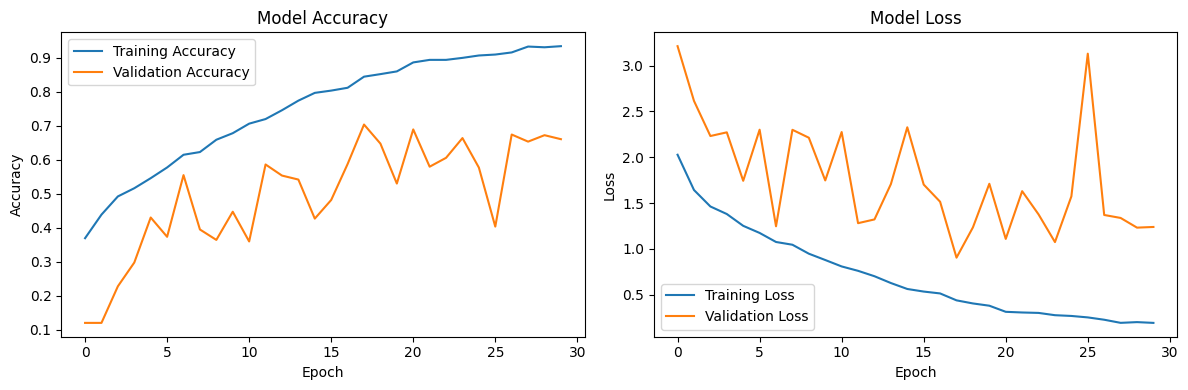

In [51]:
# Plot training results
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

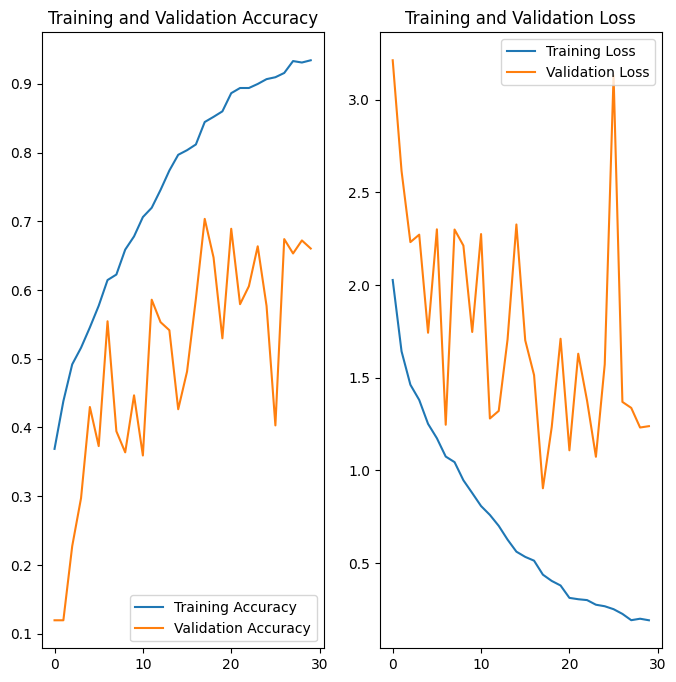

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Let's analyze the training results after using the balanced dataset:

Overall Performance Improvement:


Training accuracy improved significantly to ~93% (from previous ~57%)
Validation accuracy reached ~66% (from previous ~52%)
The model is now learning much better with the balanced dataset


Evidence of Overfitting:


Large gap between training (93%) and validation (66%) accuracy
Training loss decreased continuously to ~0.2
Validation loss shows fluctuations and is higher at ~1.2
The divergence between training and validation metrics suggests overfitting


Impact of Class Rebalancing:


Class balancing definitely helped improve overall performance
Model can now learn features from all classes more effectively
Initial convergence is faster compared to the unbalanced dataset
Training is more stable in early epochs


Areas for Further Improvement:
To address the overfitting, we could:


Increase dropout rates
Add more aggressive data augmentation
Reduce model complexity
Implement early stopping
Use L1/L2 regularization
Reduce learning rate

The class rebalancing helped solve the underfitting problem, but introduced some overfitting. This suggests the model now has enough capacity to learn the patterns but might be memorizing the training data too well.
